### ex3 Multiclass classification and neural networks

You will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

##### Input data
1. ex3data1.mat Training sets of handwritten digits. There are 5000 training examples, where each training example is a 20 pixel by 20 pixel grayscale image of the digits. This gives us a 5000*400 matrix X where each row is a training example fro the handwritten image. 

2. ex3weights.mat Initial weights for the neural networks exercise

### Part I: Multi-class classification

We will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognizition is widely used today-from recognizing zip codes on mail evenopes to recognize amounts written on bank checks. 

#### 1. Load the data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
data=loadmat('ex3data1.mat') # loaded data is a dictionary

In [3]:
# You will have X, y, Xval, yval, Xtest, ytest in your environment
print(type(data))
print('')
print(data.keys())

<class 'dict'>

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [4]:
X=np.array(data['X'])
print(X.shape)
y=np.array(data['y'])
print(y.shape)

(5000, 400)
(5000, 1)


In [13]:
input_layer_size  = 400  # 20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10   

#### 2. Viaualizing the data

We will begin by visualizing a subset of the training data. The code randomly selects 100 rows from X and passes those rows to the displayData function. The function maps each row to a 20 pixel by 20 pixel grayscale image and displays the image together.

In [5]:
def displayData(X, example_width):
    """
    DISPLAYDATA Display 2D data in a nice grid 
    [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data  stored in X in a nice grid. 
    It returns the figure handle h and the display array if requested
    """
    # closes previously opened figure. Prevent a warning after open too many figures
    plt.close()
    # create new figure
    plt.figure()
    
    # Turn 1-D X array into 2D
    if X.ndim==1:
        X=np.reshape(X,(-1,X.shape[0]))
    
# Set example_width automatically if not passed in
    if not example_width or not "example_width" in locals():
        example_width=int(round(math.sqrt(X.shape[1])))

# Gray Image
    plt.set_cmap("gray")

# Compute rows, cols
    m,n=X.shape
    example_height = int((n / example_width))

# Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

# Between images padding
    pad = 1;

# Setup blank display
    display_array = - np.ones((int(pad + display_rows * (example_height + pad)),int(pad + display_cols * (example_width + pad))))

# Copy each example into a patch on the display array
    curr_ex = 1;
    for j in range(1,display_rows+1):
        for i in range(1,display_cols+1):
            if curr_ex > m:
                break; 

# Get the max value of the patch
            max_val = max(abs(X[curr_ex-1, :]))
            rows=pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols=pad + (i - 1) * (example_width + pad) + np.array(range(example_width))
    
            display_array[rows[0]:rows[-1]+1, cols[0]:cols[-1]+1]=np.reshape(X[curr_ex-1,:],(example_height, example_width), order='F')/max_val
            curr_ex+=1
        if curr_ex>m:
            break
    h=plt.imshow(display_array,vmin=-1, vmax=1)
    
    # do not show axis
    plt.axis('off')
    plt.show(block=False)

    return h, display_array


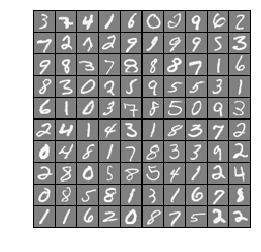

(<matplotlib.image.AxesImage at 0xa5d9b00>,
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        ..., 
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]))

In [6]:
m,n=X.shape
sub=np.array(pd.DataFrame(X).sample(100))
# randomly select 100 data points to display
displayData(sub,False)

#### 3. Vectorizing logistic regression


In [7]:
# flatten y for later purposes
y=y.flatten()
print(y.shape)

(5000,)


In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-1*z))
    """
    SIGMOID Compute sigmoid function
    g = SIGMOID(z) computes the sigmoid of z.
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """ 

In [10]:
def lrCostFunction(theta, X, y, lambda_reg, return_grad=False):
#LRCOSTFUNCTION Compute cost and gradient for logistic regression with 
#regularization
#   J = LRCOSTFUNCTION(theta, X, y, lambda_reg) computes the cost of using
#   theta as the parameter for regularized logistic regression and the
#   gradient of the cost w.r.t. to the parameters. 

    import numpy as np
    import sys

    # Initialize some useful values
    m = len(y) # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the cost of a particular choice of theta.
    #               You should set J to the cost.
    #               Compute the partial derivatives and set grad to the partial
    #               derivatives of the cost w.r.t. each parameter in theta
    #

    # taken from costFunctionReg.py
    one = y * np.transpose(np.log( sigmoid( np.dot(X,theta) ) ))
    two = (1-y) * np.transpose(np.log( 1 - sigmoid( np.dot(X,theta) ) ))
    reg = ( float(lambda_reg) / (2*m)) * np.power(theta[1:theta.shape[0]],2).sum()
    J = -(1./m)*(one+two).sum() + reg

    grad = (1./m) * np.dot(sigmoid( np.dot(X,theta) ).T - y, X).T + ( float(lambda_reg) / m )*theta

    # the case of j = 0 (recall that grad is a n+1 vector)
    grad_no_regularization = (1./m) * np.dot(sigmoid( np.dot(X,theta) ).T - y, X).T

    # and then assign only the first element of grad_no_regularization to grad
    grad[0] = grad_no_regularization[0]

    # display cost at each iteration
    sys.stdout.write("Cost: %f   \r" % (J) )
    sys.stdout.flush()

    if return_grad:
        return J, grad.flatten()
    else:
        return J

    # =============================================================

In [11]:
# test case for lrCostFunction
theta_t=np.array([-2,-1,1,2]).reshape([-1,1])
X_t=np.column_stack((np.ones((5,1)),np.arange(1,16).reshape((5,3))/10))
y_t=np.array([1,0,1,0,1]).reshape(5,)
lambda_t=3

In [12]:
J,grad=lrCostFunction(theta_t, X_t, y_t, lambda_t,return_grad=True)
print(J)
print(grad)

2.590000694421   
[-0.1212565  -0.60310931  0.58476504  1.17263939]


In [186]:
# Result not the same as answer in the matlab code. But python codes from other people has the same results as me
print('the calculated cost from the lrcostFunction is: ', J)
print('Excepted cost is 2.534819\n')
print('Calculated gradient is \n')
print(grad)
print('expected gradient is \n')
print('0.146561\n -0.548558 \n0.724722 \n1.398003')

the calculated cost from the lrcostFunction is:  2.59000069442
Excepted cost is 2.534819

Calculated gradient is 

[-0.1212565  -0.60310931  0.58476504  1.17263939]
expected gradient is 

0.146561
 -0.548558 
0.724722 
1.398003


#### 4. One-vs-all training

In this part, we will inplement the one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes. In the hand writting digits dataset K=10, but your code should work for any value of K.

In [14]:
import numpy as np
from scipy.optimize import minimize
import lrCostFunction as lrcf

def oneVsAll(X, y, num_labels, lambda_reg):

    # Some useful variables
    m, n = X.shape

    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))

    for c in range(num_labels):
        initial_theta = np.zeros((n + 1, 1))
        myargs = (X, (y%10==c).astype(int), lambda_reg, True)
        theta = minimize(lrcf.lrCostFunction, x0=initial_theta, args=myargs, options={'disp': True, 'maxiter':13}, method="Newton-CG", jac=True)
        all_theta[c,:] = theta["x"]

    return all_theta

In [16]:
lambda_reg = 0.1
np.random.seed(seed=1)
all_theta = oneVsAll(X, y, num_labels, lambda_reg)

         Current function value: 0.008568
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 316
         Hessian evaluations: 0
         Current function value: 0.013411
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 194
         Hessian evaluations: 0
         Current function value: 0.050804
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 405
         Hessian evaluations: 0
         Current function value: 0.057694
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 394
         Hessian evaluations: 0
         Current function value: 0.033222
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 277
         Hessian evaluations: 0
         Current function value: 0.054950
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 305
         Hessian evaluations: 

#### 5. Predict for one-vs-all

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the probability that it belongs to each class using the trained logistic regression classifier. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier output the highest probability and returns the class label (1,2,3,...K) as the prediction for the input example.

In [17]:
def predictOneVsAll(all_theta, X):
#PREDICT Predict the label for a trained one-vs-all classifier. The labels 
#are in the range 1..K, where K = size(all_theta, 1). 
#  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
#  for each example in the matrix X. Note that X contains the examples in
#  rows. all_theta is a matrix where the i-th row is a trained logistic
#  regression theta vector for the i-th class. You should set p to a vector
#  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
#  for 4 examples) 

    m = X.shape[0];
    num_labels = all_theta.shape[0];

# You need to return the following variables correctly 
    p = np.zeros((m,1));
    p_total = np.zeros((m,num_labels))

# Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))
    for i in range(1,num_labels):
        p_total[:,i]=np.dot(X,all_theta[i,:].T)
    
    p=np.argmax(p_total, axis=1).reshape(m,1)
    return p

In [18]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:f}'.format((np.mean(pred.flatten() == y.flatten()%10)*100)))

Training Set Accuracy: 91.240000


### Warning: need to check why it is different from the reference code

In [19]:

print('Training Set Accuracy: {:f}'.format((np.mean(pred.flatten() == y.flatten()%10)*100)))
print('Training Set Accuracy for 1:  {:f}'.format(np.mean(pred[500:1000]  == y.flatten()[500:1000]%10)  * 100))
print('Training Set Accuracy for 2:  {:f}'.format(np.mean(pred[1000:1500] == y.flatten()[1000:1500]%10) * 100))
print('Training Set Accuracy for 3:  {:f}'.format(np.mean(pred[1500:2000] == y.flatten()[1500:2000]%10) * 100))
print('Training Set Accuracy for 4:  {:f}'.format(np.mean(pred[2000:2500] == y.flatten()[2000:2500]%10) * 100))
print('Training Set Accuracy for 5:  {:f}'.format(np.mean(pred[2500:3000] == y.flatten()[2500:3000]%10) * 100))
print('Training Set Accuracy for 6:  {:f}'.format(np.mean(pred[3000:3500] == y.flatten()[3000:3500]%10) * 100))
print('Training Set Accuracy for 7:  {:f}'.format(np.mean(pred[3500:4000] == y.flatten()[3500:4000]%10) * 100))
print('Training Set Accuracy for 8:  {:f}'.format(np.mean(pred[4000:4500] == y.flatten()[4000:4500]%10) * 100))
print('Training Set Accuracy for 9:  {:f}'.format(np.mean(pred[4500:5000] == y.flatten()[4500:5000]%10) * 100))
print('Training Set Accuracy for 10: {:f}'.format(np.mean(pred[0:500]     == y.flatten()[0:500]%10)     * 100))

Training Set Accuracy: 91.240000
Training Set Accuracy for 1:  98.400000
Training Set Accuracy for 2:  89.600000
Training Set Accuracy for 3:  87.800000
Training Set Accuracy for 4:  94.000000
Training Set Accuracy for 5:  88.800000
Training Set Accuracy for 6:  98.000000
Training Set Accuracy for 7:  94.600000
Training Set Accuracy for 8:  78.800000
Training Set Accuracy for 9:  84.000000
Training Set Accuracy for 10: 98.400000


### Part II: Neural networks

Logistic regression cannot form nonlinear hypothesis. Now we use a parameters from a neural network that we already trained. The goal is to implement the feedforward propagation algorithm to use your weights for prediction. In the next weeks we will write the backpropagation algorithm for learning the neural networks algorithms. 

#### 1. Model representation

There is an input layer, a hidden layer and an output layer. The input layer is a 400 units. There are 25 units in the second layer and 10 units as the output layer.

In [20]:
weights=loadmat('ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [27]:
Theta1=weights['Theta1']
print(Theta1.shape)
Theta2=weights['Theta2']
print(Theta2.shape)

(25, 401)
(10, 26)


In [28]:
from scipy.io import loadmat
data=loadmat('ex3data1.mat')
X=data['X']
y=data['y']
y=y.flatten()

## Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

In [29]:
def predict(Theta1, Theta2, X):
#PREDICT Predict the label for a trained one-vs-all classifier. The labels 
#are in the range 1..K, where K = size(all_theta, 1). 
#  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
#  for each example in the matrix X. Note that X contains the examples in
#  rows. all_theta is a matrix where the i-th row is a trained logistic
#  regression theta vector for the i-th class. You should set p to a vector
#  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
#  for 4 examples) 
# turns 1D X array into 2D
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0];
    p = np.zeros((m,1))
    num_labels = Theta2.shape[0];
    # Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))
    
    layer2=sigmoid(np.dot(X,Theta1.T))
    
    # add 1 for layer 2
    layer2 = np.column_stack((np.ones((m,1)), layer2))
    p_total=sigmoid(np.dot(layer2,Theta2.T))
    p=np.argmax(p_total, axis=1)
    return p+1

In [30]:
pred = predict(Theta1, Theta2, X);
print('Training Set Accuracy: {:f}'.format((np.mean(pred == y)*100)))

Training Set Accuracy: 97.520000


In [31]:
print('Training Set Accuracy: {:f}'.format((np.mean(pred.flatten() == y.flatten())*100)))
print('Training Set Accuracy for 1:  {:f}'.format(np.mean(pred[500:1000]  == y.flatten()[500:1000])  * 100))
print('Training Set Accuracy for 2:  {:f}'.format(np.mean(pred[1000:1500] == y.flatten()[1000:1500]) * 100))
print('Training Set Accuracy for 3:  {:f}'.format(np.mean(pred[1500:2000] == y.flatten()[1500:2000]) * 100))
print('Training Set Accuracy for 4:  {:f}'.format(np.mean(pred[2000:2500] == y.flatten()[2000:2500]) * 100))
print('Training Set Accuracy for 5:  {:f}'.format(np.mean(pred[2500:3000] == y.flatten()[2500:3000]) * 100))
print('Training Set Accuracy for 6:  {:f}'.format(np.mean(pred[3000:3500] == y.flatten()[3000:3500]) * 100))
print('Training Set Accuracy for 7:  {:f}'.format(np.mean(pred[3500:4000] == y.flatten()[3500:4000]) * 100))
print('Training Set Accuracy for 8:  {:f}'.format(np.mean(pred[4000:4500] == y.flatten()[4000:4500]) * 100))
print('Training Set Accuracy for 9:  {:f}'.format(np.mean(pred[4500:5000] == y.flatten()[4500:5000]) * 100))
print('Training Set Accuracy for 10: {:f}'.format(np.mean(pred[0:500]     == y.flatten()[0:500])     * 100))

Training Set Accuracy: 97.520000
Training Set Accuracy for 1:  98.200000
Training Set Accuracy for 2:  97.000000
Training Set Accuracy for 3:  96.000000
Training Set Accuracy for 4:  96.800000
Training Set Accuracy for 5:  98.400000
Training Set Accuracy for 6:  98.600000
Training Set Accuracy for 7:  97.000000
Training Set Accuracy for 8:  98.200000
Training Set Accuracy for 9:  95.800000
Training Set Accuracy for 10: 99.200000


In [33]:
y[0]

10

display example image


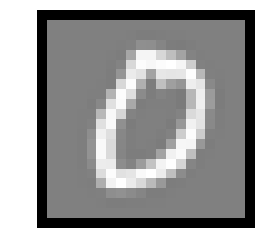

Neural Network Prediction: 10 (digit 0)
display example image


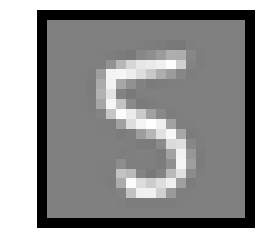

Neural Network Prediction: 5 (digit 5)
display example image


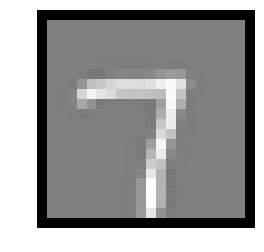

Neural Network Prediction: 7 (digit 7)
display example image


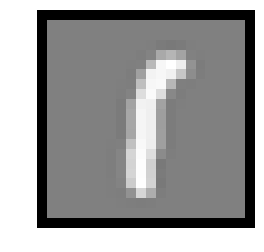

Neural Network Prediction: 1 (digit 1)
display example image


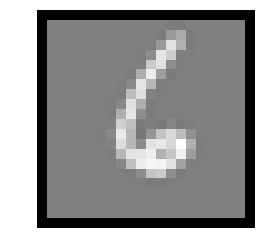

Neural Network Prediction: 6 (digit 6)
display example image


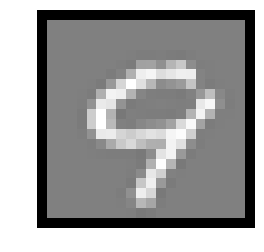

Neural Network Prediction: 9 (digit 9)
display example image


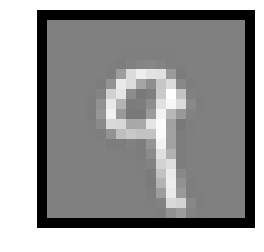

Neural Network Prediction: 9 (digit 9)
display example image


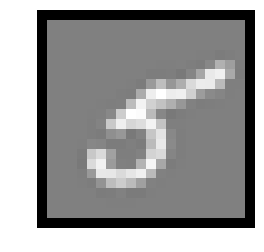

Neural Network Prediction: 5 (digit 5)
display example image


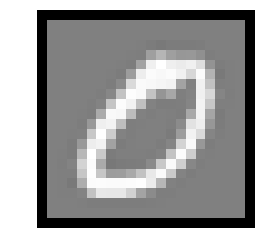

Neural Network Prediction: 10 (digit 0)
display example image


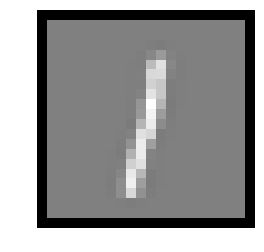

Neural Network Prediction: 1 (digit 1)
display example image


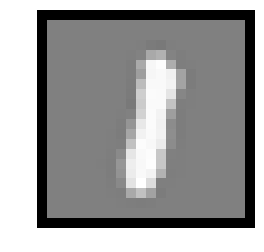

Neural Network Prediction: 1 (digit 1)
display example image


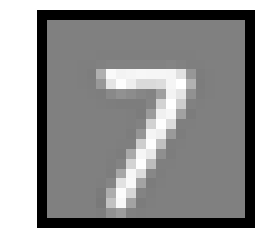

Neural Network Prediction: 7 (digit 7)
display example image


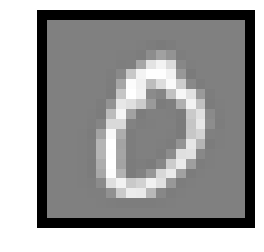

Neural Network Prediction: 10 (digit 0)
display example image


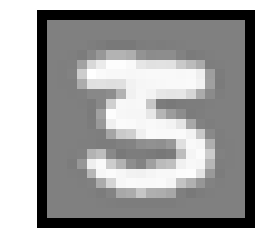

Neural Network Prediction: 3 (digit 3)
display example image


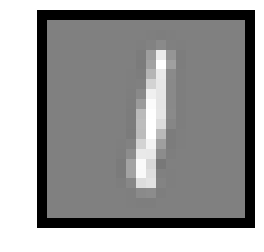

Neural Network Prediction: 1 (digit 1)
display example image


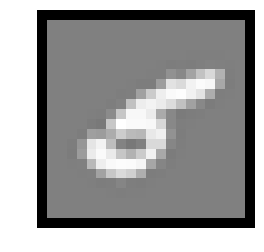

Neural Network Prediction: 5 (digit 5)
display example image


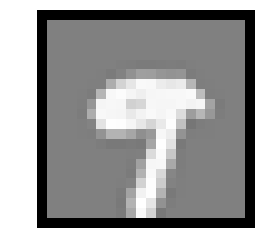

Neural Network Prediction: 9 (digit 9)
display example image


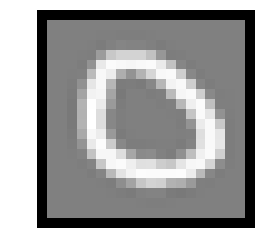

Neural Network Prediction: 10 (digit 0)
display example image


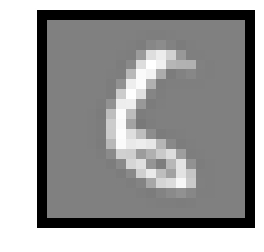

Neural Network Prediction: 6 (digit 6)
display example image


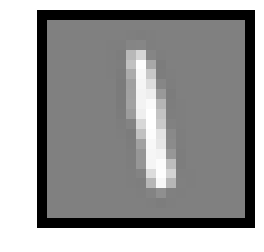

Neural Network Prediction: 1 (digit 1)
display example image


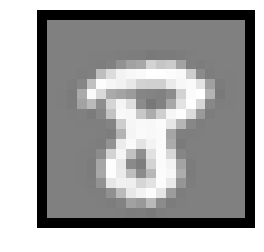

Neural Network Prediction: 8 (digit 8)
display example image


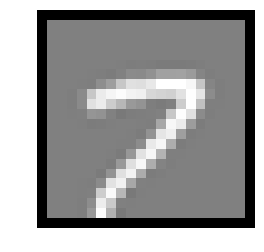

Neural Network Prediction: 7 (digit 7)
display example image


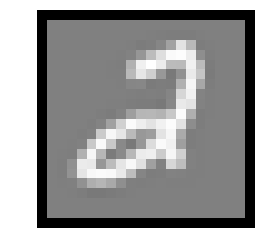

Neural Network Prediction: 2 (digit 2)
display example image


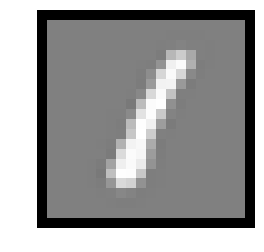

Neural Network Prediction: 1 (digit 1)
display example image


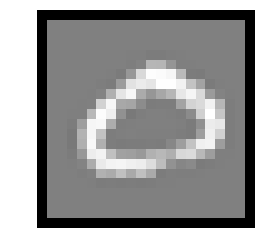

Neural Network Prediction: 10 (digit 0)
display example image


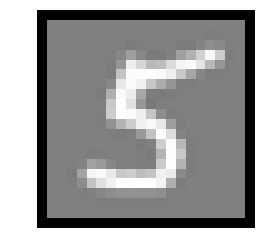

Neural Network Prediction: 5 (digit 5)
display example image


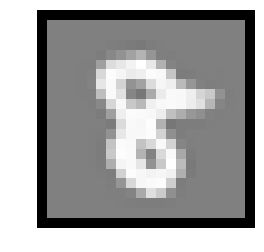

Neural Network Prediction: 8 (digit 8)
display example image


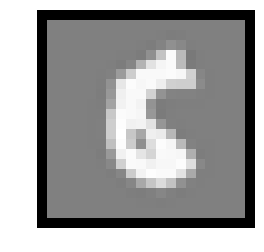

Neural Network Prediction: 8 (digit 8)
display example image


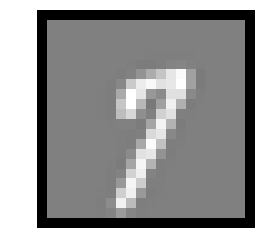

Neural Network Prediction: 7 (digit 7)
display example image


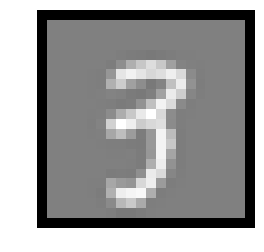

Neural Network Prediction: 3 (digit 3)
display example image


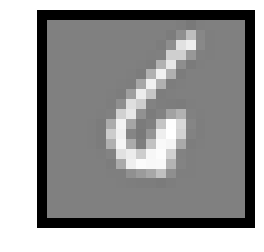

Neural Network Prediction: 6 (digit 6)
display example image


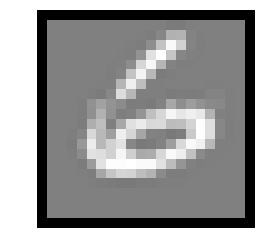

Neural Network Prediction: 6 (digit 6)
display example image


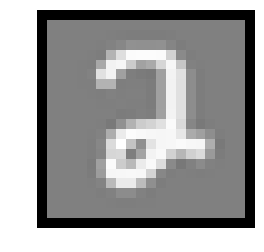

Neural Network Prediction: 2 (digit 2)
display example image


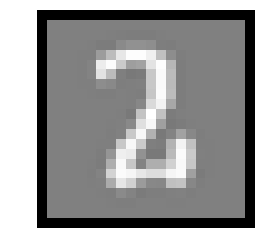

Neural Network Prediction: 2 (digit 2)
display example image


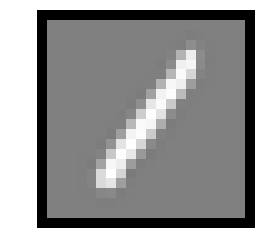

Neural Network Prediction: 1 (digit 1)
display example image


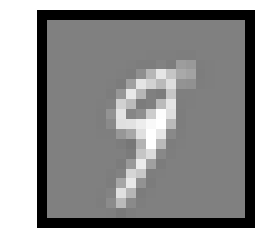

Neural Network Prediction: 9 (digit 9)
display example image


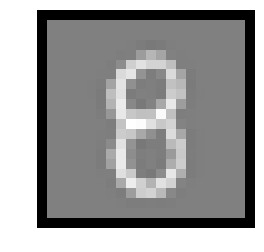

Neural Network Prediction: 8 (digit 8)
display example image


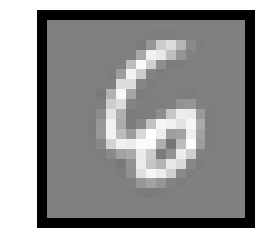

Neural Network Prediction: 6 (digit 6)
display example image


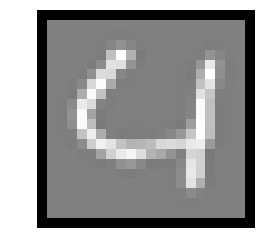

Neural Network Prediction: 4 (digit 4)
display example image


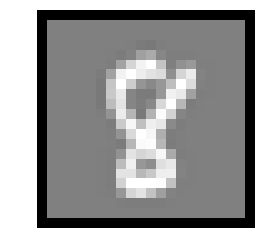

Neural Network Prediction: 8 (digit 8)
display example image


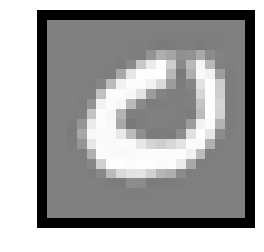

Neural Network Prediction: 10 (digit 0)
display example image


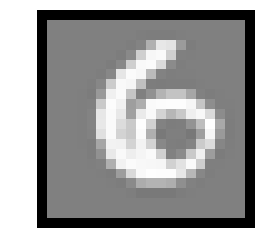

Neural Network Prediction: 6 (digit 6)
display example image


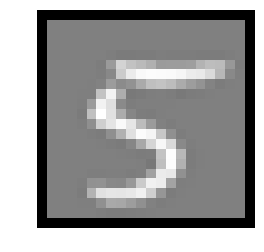

Neural Network Prediction: 5 (digit 5)
display example image


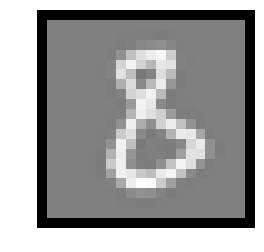

Neural Network Prediction: 8 (digit 8)
display example image


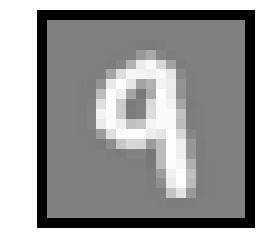

Neural Network Prediction: 9 (digit 9)
display example image


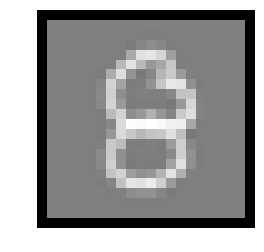

Neural Network Prediction: 8 (digit 8)
display example image


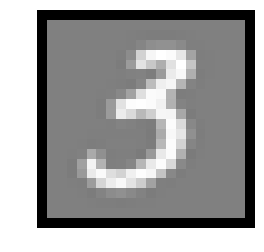

Neural Network Prediction: 3 (digit 3)
display example image


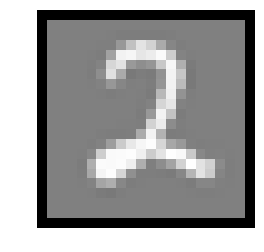

Neural Network Prediction: 2 (digit 2)
display example image


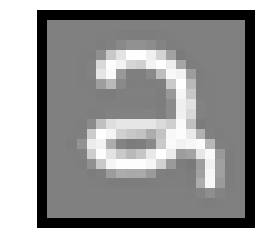

Neural Network Prediction: 2 (digit 2)
display example image


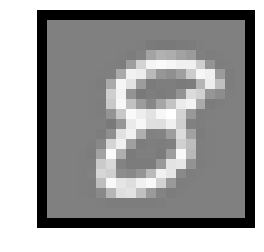

Neural Network Prediction: 8 (digit 8)
display example image


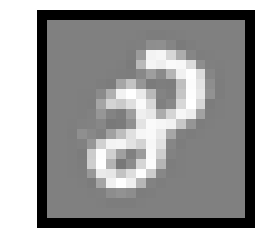

Neural Network Prediction: 8 (digit 8)
display example image


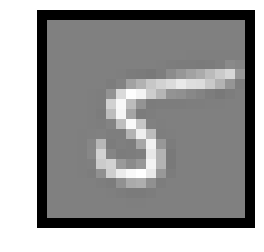

Neural Network Prediction: 5 (digit 5)
display example image


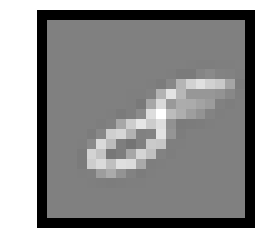

Neural Network Prediction: 4 (digit 4)
display example image


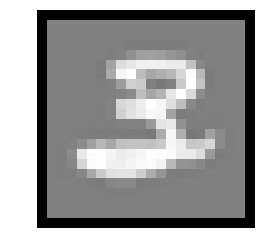

Neural Network Prediction: 3 (digit 3)
display example image


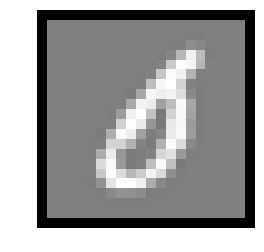

Neural Network Prediction: 10 (digit 0)
display example image


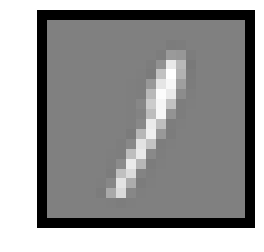

Neural Network Prediction: 1 (digit 1)
display example image


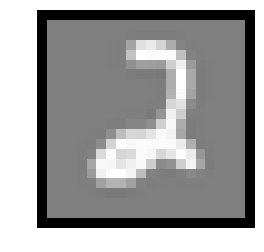

Neural Network Prediction: 2 (digit 2)
display example image


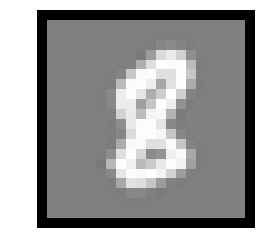

Neural Network Prediction: 8 (digit 8)
display example image


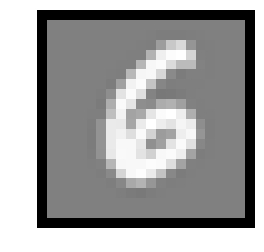

Neural Network Prediction: 6 (digit 6)
display example image


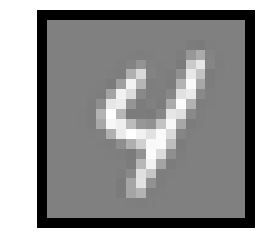

Neural Network Prediction: 4 (digit 4)
display example image


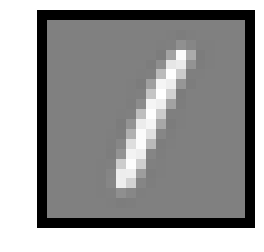

Neural Network Prediction: 1 (digit 1)
display example image


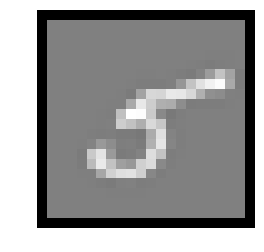

Neural Network Prediction: 5 (digit 5)
display example image


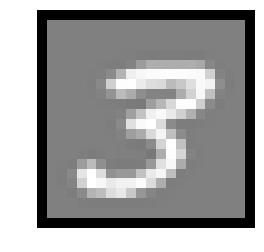

Neural Network Prediction: 3 (digit 3)
display example image


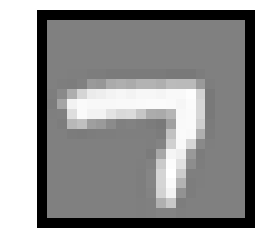

Neural Network Prediction: 7 (digit 7)
display example image


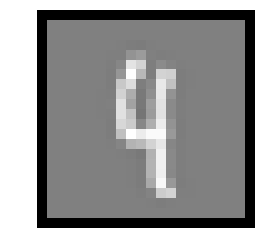

Neural Network Prediction: 4 (digit 4)
display example image


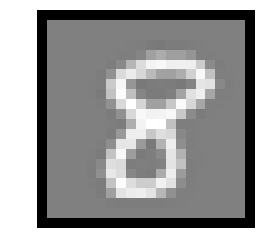

Neural Network Prediction: 8 (digit 8)
display example image


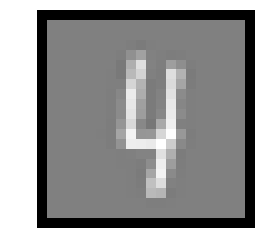

Neural Network Prediction: 4 (digit 4)
display example image


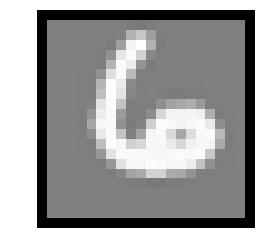

Neural Network Prediction: 6 (digit 6)
display example image


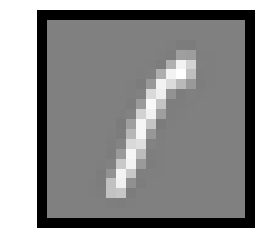

Neural Network Prediction: 1 (digit 1)
display example image


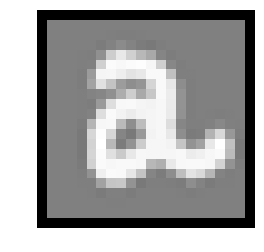

Neural Network Prediction: 2 (digit 2)
display example image


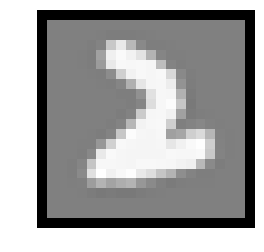

Neural Network Prediction: 2 (digit 2)
display example image


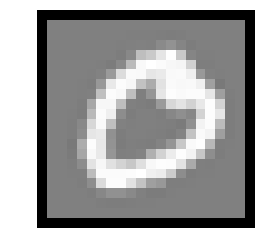

Neural Network Prediction: 10 (digit 0)
display example image


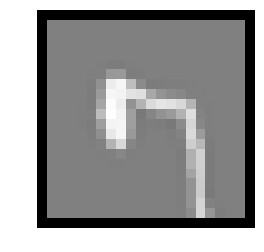

Neural Network Prediction: 4 (digit 4)
display example image


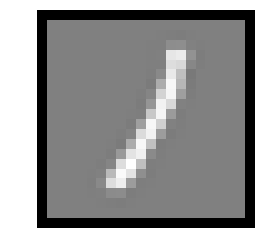

Neural Network Prediction: 1 (digit 1)
display example image


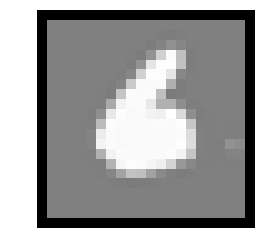

Neural Network Prediction: 6 (digit 6)
display example image


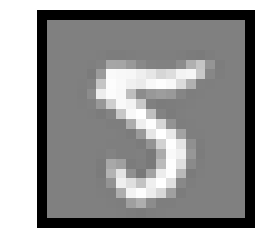

Neural Network Prediction: 5 (digit 5)
display example image


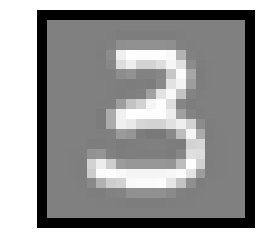

Neural Network Prediction: 3 (digit 3)
display example image


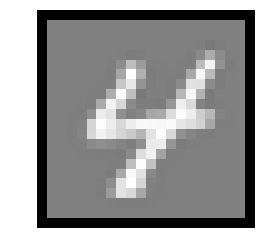

Neural Network Prediction: 4 (digit 4)
display example image


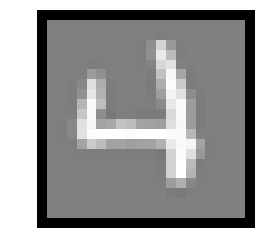

Neural Network Prediction: 4 (digit 4)
display example image


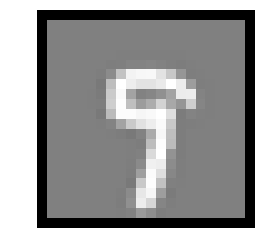

Neural Network Prediction: 9 (digit 9)
display example image


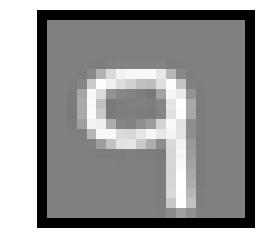

Neural Network Prediction: 9 (digit 9)
display example image


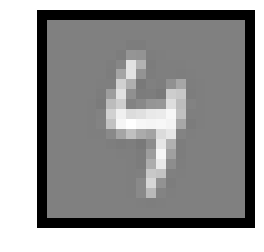

Neural Network Prediction: 4 (digit 4)
display example image


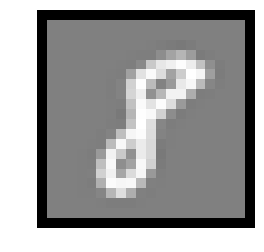

Neural Network Prediction: 8 (digit 8)
display example image


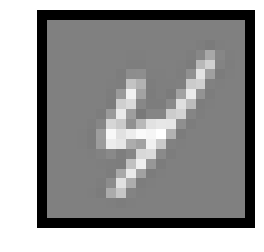

Neural Network Prediction: 4 (digit 4)
display example image


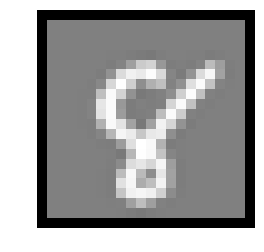

Neural Network Prediction: 8 (digit 8)
display example image


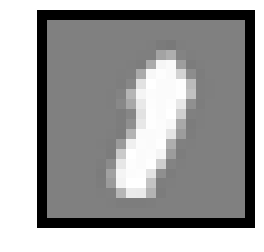

Neural Network Prediction: 1 (digit 1)
display example image


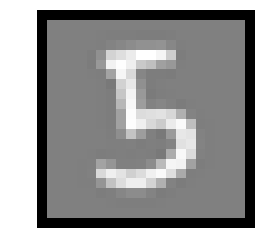

Neural Network Prediction: 5 (digit 5)
display example image


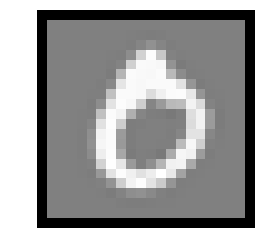

Neural Network Prediction: 10 (digit 0)
display example image


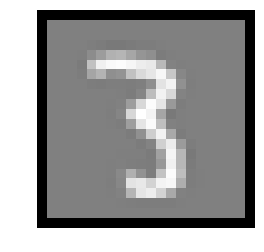

Neural Network Prediction: 3 (digit 3)
display example image


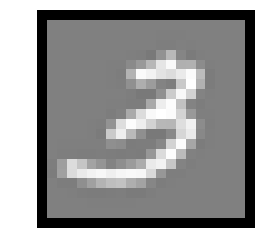

Neural Network Prediction: 3 (digit 3)
display example image


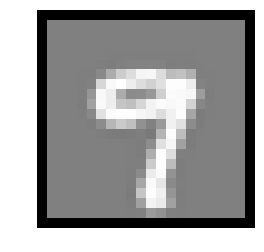

Neural Network Prediction: 9 (digit 9)
display example image


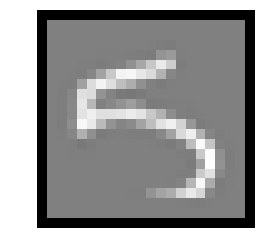

Neural Network Prediction: 5 (digit 5)
display example image


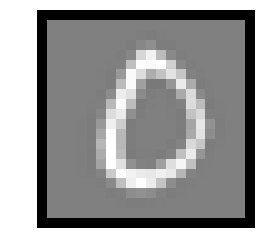

Neural Network Prediction: 10 (digit 0)
display example image


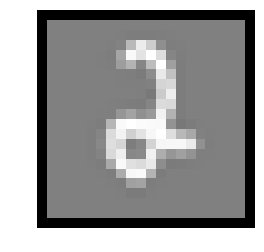

Neural Network Prediction: 2 (digit 2)
display example image


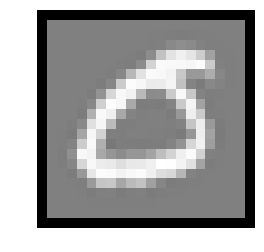

Neural Network Prediction: 10 (digit 0)
display example image


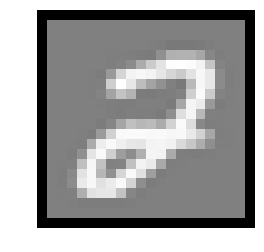

Neural Network Prediction: 2 (digit 2)
display example image


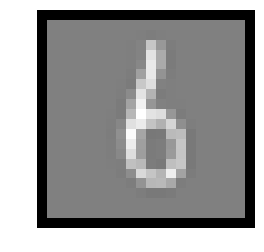

Neural Network Prediction: 6 (digit 6)
display example image


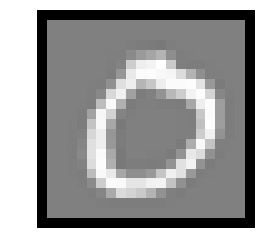

Neural Network Prediction: 10 (digit 0)
display example image


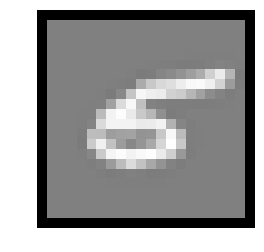

Neural Network Prediction: 5 (digit 5)
display example image


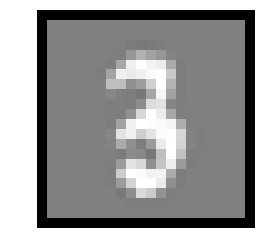

Neural Network Prediction: 3 (digit 3)
display example image


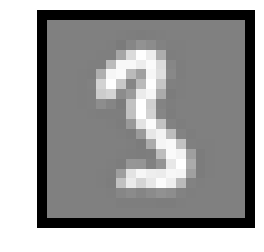

Neural Network Prediction: 3 (digit 3)
display example image


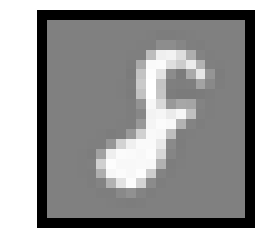

Neural Network Prediction: 8 (digit 8)
display example image


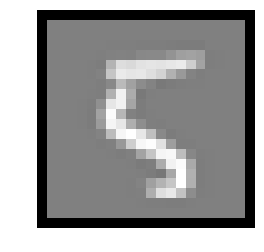

Neural Network Prediction: 5 (digit 5)
display example image


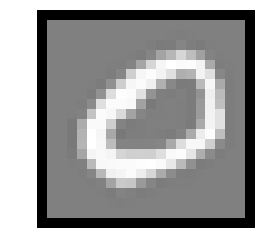

Neural Network Prediction: 10 (digit 0)
display example image


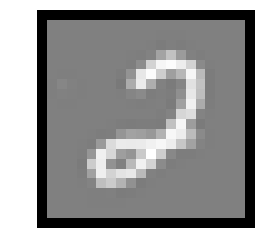

Neural Network Prediction: 2 (digit 2)
display example image


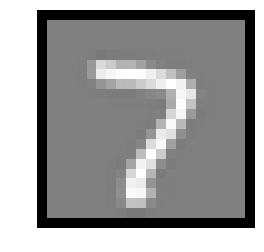

Neural Network Prediction: 7 (digit 7)
display example image


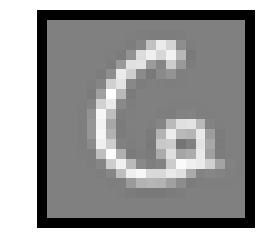

Neural Network Prediction: 6 (digit 6)
display example image


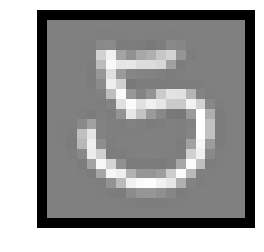

Neural Network Prediction: 5 (digit 5)
display example image


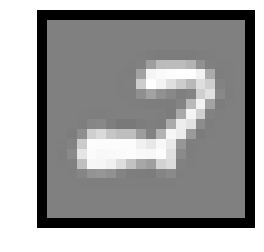

Neural Network Prediction: 2 (digit 2)
display example image


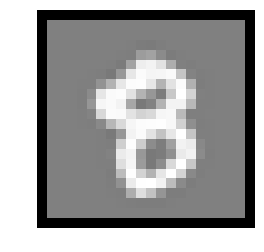

Neural Network Prediction: 8 (digit 8)
display example image


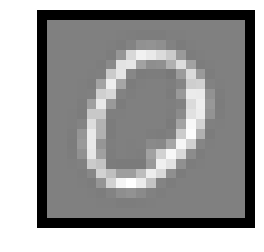

Neural Network Prediction: 10 (digit 0)
display example image


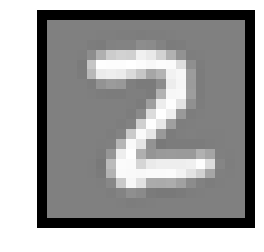

Neural Network Prediction: 2 (digit 2)
display example image


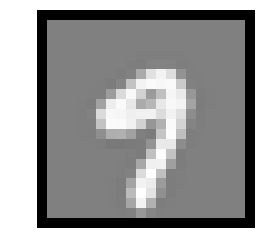

Neural Network Prediction: 9 (digit 9)
display example image


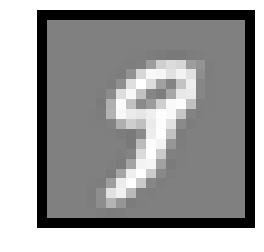

Neural Network Prediction: 9 (digit 9)
display example image


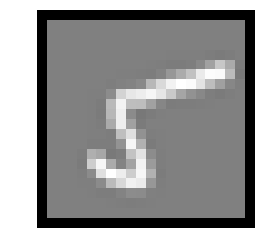

Neural Network Prediction: 5 (digit 5)
display example image


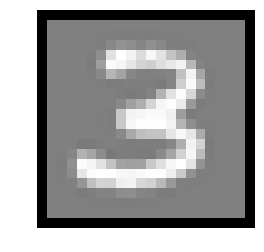

Neural Network Prediction: 3 (digit 3)
display example image


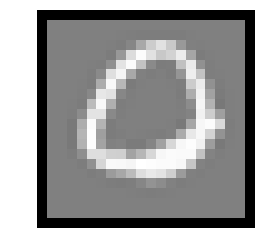

Neural Network Prediction: 10 (digit 0)
display example image


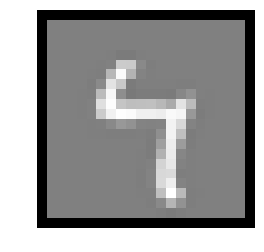

Neural Network Prediction: 4 (digit 4)
display example image


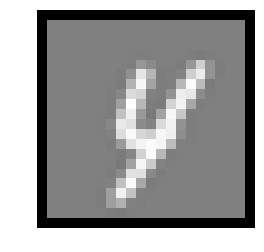

Neural Network Prediction: 4 (digit 4)
display example image


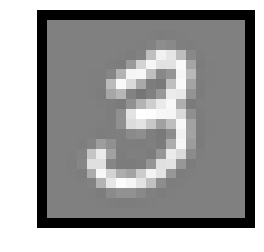

Neural Network Prediction: 3 (digit 3)
display example image


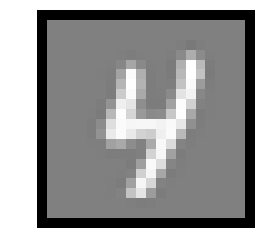

Neural Network Prediction: 4 (digit 4)
display example image


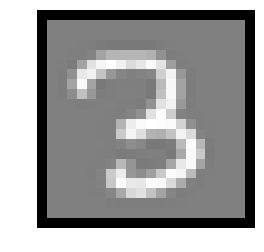

Neural Network Prediction: 3 (digit 3)
display example image


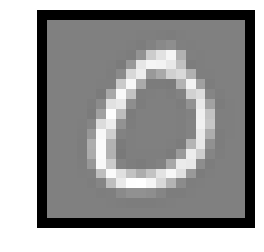

Neural Network Prediction: 10 (digit 0)
display example image


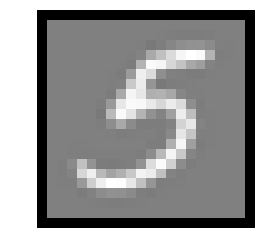

Neural Network Prediction: 5 (digit 5)
display example image


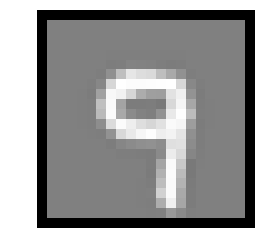

Neural Network Prediction: 9 (digit 9)
display example image


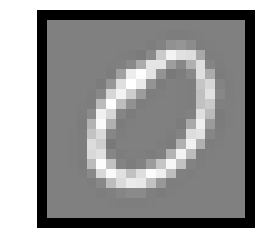

Neural Network Prediction: 10 (digit 0)
display example image


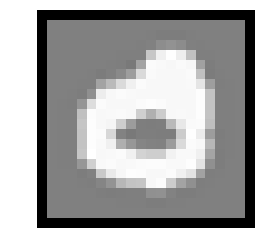

Neural Network Prediction: 10 (digit 0)
display example image


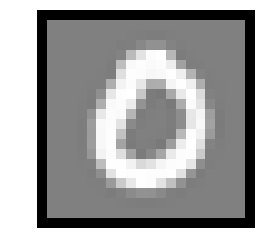

Neural Network Prediction: 10 (digit 0)
display example image


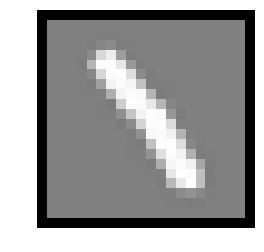

Neural Network Prediction: 3 (digit 3)
display example image


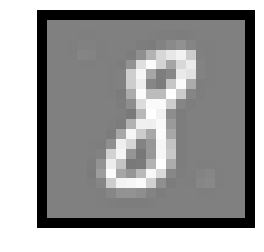

Neural Network Prediction: 8 (digit 8)
display example image


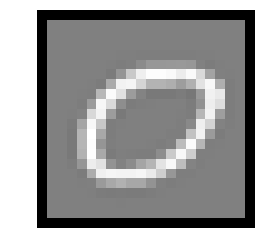

Neural Network Prediction: 10 (digit 0)
display example image


KeyboardInterrupt: 

In [35]:
# to get an idea of the network's output, you can also run through the examples one at a time to see what it is predicting
# randomly permute examples. If we do not permutation, then the first 500 will be 0, followed by 1,2
rp=np.random.permutation(m)
for i in range(m):
    print('display example image')
    displayData(X[rp[i],:], False)
    pred=predict(Theta1, Theta2, X[rp[i],:])
    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred%10)[0]))

In [36]:
10000*9999/2

49995000.0